In [1]:
%matplotlib inline

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits

from dataset import CellsDataset, PatchedDataset
from model import UNet
from utils import plot_cells, plot_mask_cells, plot_masks

torch.manual_seed(12);

In [2]:
with open("train_valid_split.json", "r") as fp:
    train_valid_split = json.load(fp)
    
train_dirs = [Path(d) for d in train_valid_split['train_dirs']]
valid_dirs = [Path(d) for d in train_valid_split['valid_dirs']]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

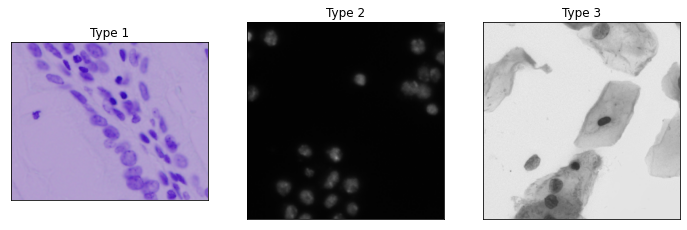

In [3]:
type1_id, type2_id, type3_id = 13, 6, 25
_ = plot_cells(valid_cell_ds[type1_id][0],
              valid_cell_ds[type2_id][0],
              valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))

Most of the data is of type 2. Training a single model to be able to find the nuclei for all types may nor be the best option.

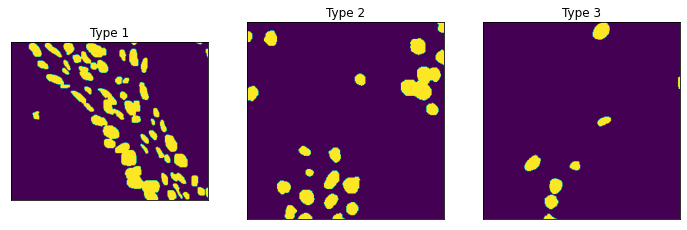

In [4]:
_ = plot_masks(valid_cell_ds[type1_id][1],
               valid_cell_ds[type2_id][1],
               valid_cell_ds[type3_id][1].crop((200, 200, 500, 500)))

For our dataset, we break our images into 256x256 patches. The UNet architecture typically has a hard time dealing with objects on the edge of an image. In order to deal with this issue, we pad our images by 16 using reflection which is handled by PatchedDataset

In [5]:
train_ds = PatchedDataset(train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

In [6]:
model = UNet(pretrained=True)

In [7]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

In [8]:
def approximate_iou_metric(true_masks, predicted_logit_masks, padding=16):
    true_masks = true_masks[:, padding:-padding, padding:-padding]
    predicted_logit_masks = predicted_logit_masks[:, padding:-padding, padding:-padding]
    predicted_masks = 1/(1+np.exp(-predicted_logit_masks))
    
    approx_intersect = np.sum(np.minimum(predicted_masks, true_masks), axis=(1,2))
    approx_union = np.sum(np.maximum(predicted_masks, true_masks), axis=(1,2))
    return np.mean(approx_intersect/approx_union)

In [9]:
from skorch.callbacks import EpochScoring
from skorch.utils import to_numpy

In [10]:
def iou_scoring(net, ds, y):
    predicted_logit_masks = net.predict(ds)
    return approximate_iou_metric(y, predicted_logit_masks)

iou_scoring = EpochScoring(iou_scoring, name='iou', lower_is_better=False)

In [11]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR

cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.2,
                       step_size_up=540,
                       step_size_down=540)

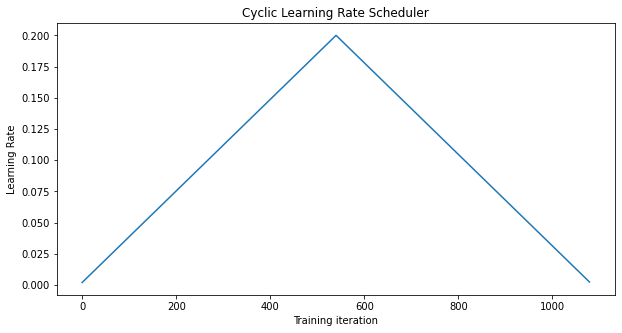

In [12]:
_, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
_ = ax.plot(cyclicLR.simulate(1080, 0.002))

In [13]:
class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding=16):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return binary_cross_entropy_with_logits(input, target)

In [16]:
from skorch.callbacks import Checkpoint
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
        model,
        criterion=BCEWithLogitsLossPadding,
    criterion__padding=16,
    batch_size=16,
    max_epochs=20,
    optimizer=SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    train_split=predefined_split(val_ds),
    callbacks=[freezer,
               cyclicLR, 
               iou_scoring,
               Checkpoint(f_params='best_params.pt')],
    device='cuda',
)

In [17]:
if __name__ == '__main__':
    net.fit(train_ds);

  epoch     iou    train_loss    valid_loss    cp      lr       dur
-------  ------  ------------  ------------  ----  ------  --------
      1  0.1271        0.3518        0.3494     +  0.0020  110.3491
      2  0.1428        0.3379        0.3381     +  0.0024  125.0844
      3  0.1629        0.3235        0.3168     +  0.0027  132.5730
      4  0.2019        0.2995        0.2930     +  0.0031  135.9230
      5  0.2666        0.2613        0.2452     +  0.0035  136.7022
      6  0.3580        0.2166        0.2018     +  0.0038  136.7095
      7  0.4287        0.1716        0.1634     +  0.0042  138.4398
      8  0.4918        0.1539        0.1366     +  0.0046  139.7155
      9  0.5476        0.1304        0.1167     +  0.0049  140.3386
     10  0.6100        0.1179        0.0889     +  0.0053  143.5773
     11  0.6336        0.0931        0.0800     +  0.0057  142.2722
     12  0.6290        0.0873        0.0947        0.0060  140.3785
     13  0.6730        0.0827        0.0728     

In [18]:
val_masks = net.predict(val_ds).squeeze(1)
val_prob_masks = 1/(1+np.exp(-val_masks))

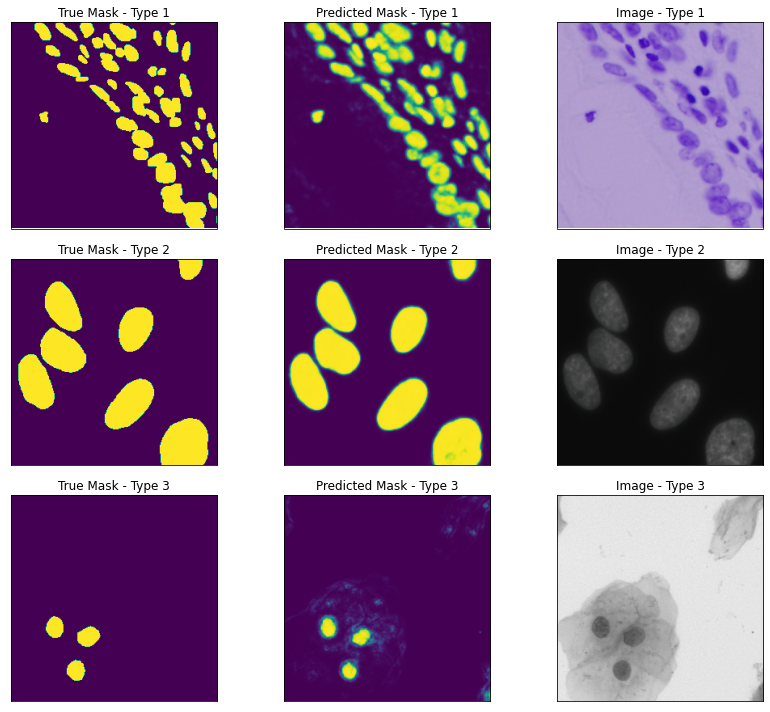

In [19]:
mask_cells = []
for case_id in [45, 8, 81]:
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

_ = plot_mask_cells(mask_cells)